# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-and-process" data-toc-modified-id="Load-and-process-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and process</a></div><div class="lev2 toc-item"><a href="#Geocode-properties" data-toc-modified-id="Geocode-properties-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Geocode properties</a></div><div class="lev1 toc-item"><a href="#Data-dictionary" data-toc-modified-id="Data-dictionary-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data dictionary</a></div><div class="lev1 toc-item"><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></div>

# Load and process

In [1]:
##Load libraries
import pandas as pd
import geopandas as gp
import requests as r
import missingno as mgno
%matplotlib inline
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

In [2]:
##Load October 2015 data
data_2015 = pd.read_csv('data/oct_2015_ov_data.csv',low_memory=False)
##Load October 2017 data
data_2017 = pd.read_sql('data',con='sqlite:///data/oct_2017_ov_data_product.sqlite')
##Add in snapshot date
data_2015['date_snapshot'] = pd.to_datetime('2015-10-31')
data_2017['date_snapshot'] = pd.to_datetime('2017-10-1')
##Combine files into a single dataframe
data = pd.concat([data_2015,data_2017])
##Exclude last row which appears to be a summary
data = data[:-1]

In [3]:
##Inspect first few rows of data
data.tail(5)

,Title_Number,Tenure,Property_Address,Price_Paid,District,County,Region,Postcode,Proprietor_Name_1,Company_Registration_No_1,...,Company_Registration_No_4,Proprietorship_4,Country_Incorporated_4,Proprietor_4_Address_1,Proprietor_4_Address_2,Proprietor_4_Address_3,Date_Proprietor_Added,Additional_Proprietor_Indicator,Multiple_Address_Indicator,date_snapshot
99214,AGL401155,Leasehold,"Apartment 2101, Wiverton Tower, 4 New Drum Str...",NaN,TOWER HAMLETS,GREATER LONDON,GREATER LONDON,E1 7AT,GS ALDGATE TRUSTEE 1 LIMITED,None,...,NaN,None,None,None,None,NaN,16-01-2017,N,N,2017-10-01
99215,AGL401163,Leasehold,"Apartment 2207, Wiverton Tower, 4 New Drum Str...",NaN,TOWER HAMLETS,GREATER LONDON,GREATER LONDON,E1 7AT,GS ALDGATE TRUSTEE 1 LIMITED,None,...,NaN,None,None,None,None,NaN,16-01-2017,N,N,2017-10-01
99216,AGL402005,Leasehold,"Flat 41, Goldhawk House, 10 Beaufort Square, L...",NaN,BARNET,GREATER LONDON,GREATER LONDON,NW9 5SQ,NOMURO NOMINEES LIMITED,None,...,NaN,None,None,None,None,NaN,24-01-2017,N,N,2017-10-01
99217,AGL402840,Leasehold,"11, Birkdale House, 18 St Annes Street, London...",390000.0,TOWER HAMLETS,GREATER LONDON,GREATER LONDON,E14 7QB,HAPPY GOAL DEVELOPMENT LTD,None,...,NaN,None,None,None,None,NaN,02-02-2017,N,N,2017-10-01
99218,AGL403429,Leasehold,"Block A, Victoria Wharf, Palmers Road, London ...",NaN,TOWER HAMLETS,GREATER LONDON,GREATER LONDON,E2 0SF,PINEHILL CAPITAL S.A.,None,...,NaN,None,None,None,None,NaN,07-02-2017,N,N,2017-10-01


In [4]:
##Create stacked version of original table which is better for counts
data.columns = ['Title_Number', 'Tenure', 'Property_Address', 'Price_Paid', 'District',\
       'County', 'Region', 'Postcode', '1-Proprietor_Name',\
       '1-Company_Registration', '1-Proprietorship',\
       '1-Country_Incorporated', '1-Proprietor_Address_1',\
       '1-Proprietor_Address_2', '1-Proprietor_Address_3', '2-Proprietor_Name',\
       '2-Company_Registration', '2-Proprietorship',\
       '2-Country_Incorporated', '2-Proprietor_Address_1',\
       '2-Proprietor_Address_2', '2-Proprietor_Address_3', '3-Proprietor_Name',\
       '3-Company_Registration', '3-Proprietorship',\
       '3-Country_Incorporated', '3-Proprietor_Address_1',\
       '3-Proprietor_Address_2', '3-Proprietor_Address_3', '4-Proprietor_Name',\
       '4-Company_Registration', '4-Proprietorship',\
       '4-Country_Incorporated', '4-Proprietor_Address_1',\
       '4-Proprietor_Address_2', '4-Proprietor_Address_3',\
       'Date_Proprietor_Added', 'Additional_Proprietor_Indicator',\
       'Multiple_Address_Indicator','date_snapshot']
data.set_index(['Title_Number', 'Tenure', 'Property_Address', 'Price_Paid', 'District',\
       'County', 'Region', 'Postcode','Date_Proprietor_Added', 'Additional_Proprietor_Indicator',\
       'Multiple_Address_Indicator','date_snapshot'], inplace=True)
tuples = tuple(data.columns.str.split("-"))
tuples = [x[::-1] for x in tuples]
data.columns = pd.MultiIndex.from_tuples(tuples)
data = data.stack(level = 1).reset_index(level = 1, drop = True).reset_index()
data.rename(columns={'level_11': 'Proprietor_Number'},inplace=True)
data.set_index('date_snapshot',inplace=True)

/Users/anna/Library/Python/2.7/lib/python/site-packages/pandas/core/algorithms.py:555: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  labels = table.get_labels(values, uniques, 0, na_sentinel, check_nulls)
/Users/anna/Library/Python/2.7/lib/python/site-packages/pandas/core/algorithms.py:481: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  sorter = values.argsort()


In [5]:
##Create a pseudo unique column for companies which is a combination of first line of address and name. May
##want to bottom this out a bit more
data['Proprietor_Address_1'] = data['Proprietor_Address_1'].fillna('')
data['Proprietor_Name'] = data['Proprietor_Name'].fillna('')
data['unique_company'] = data['Proprietor_Name'] + data['Proprietor_Address_1']

In [6]:
##Size of dataset
print(data.shape)

(208353, 19)


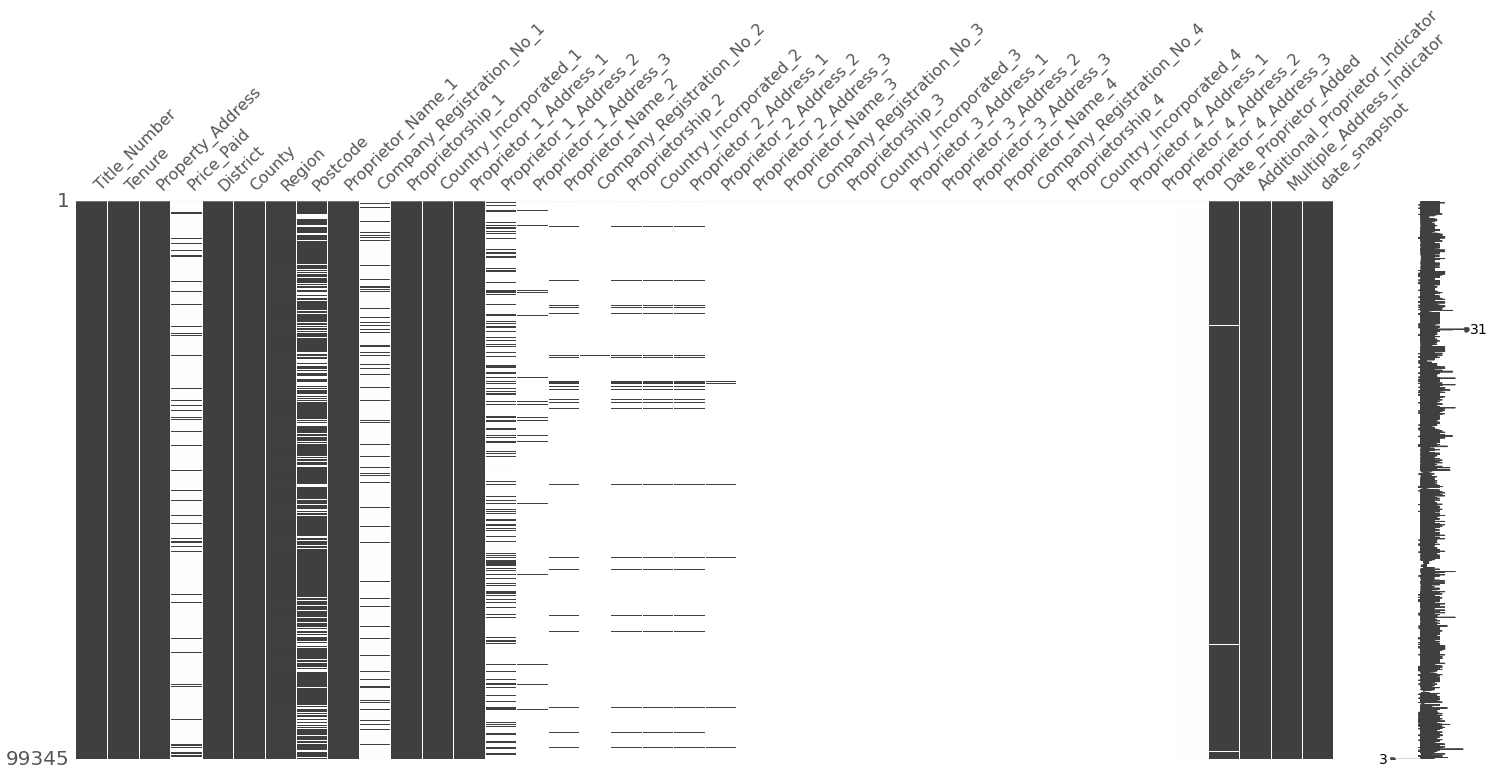

In [7]:
##Look at how well filled out fields are
mgno.matrix(data_2015)

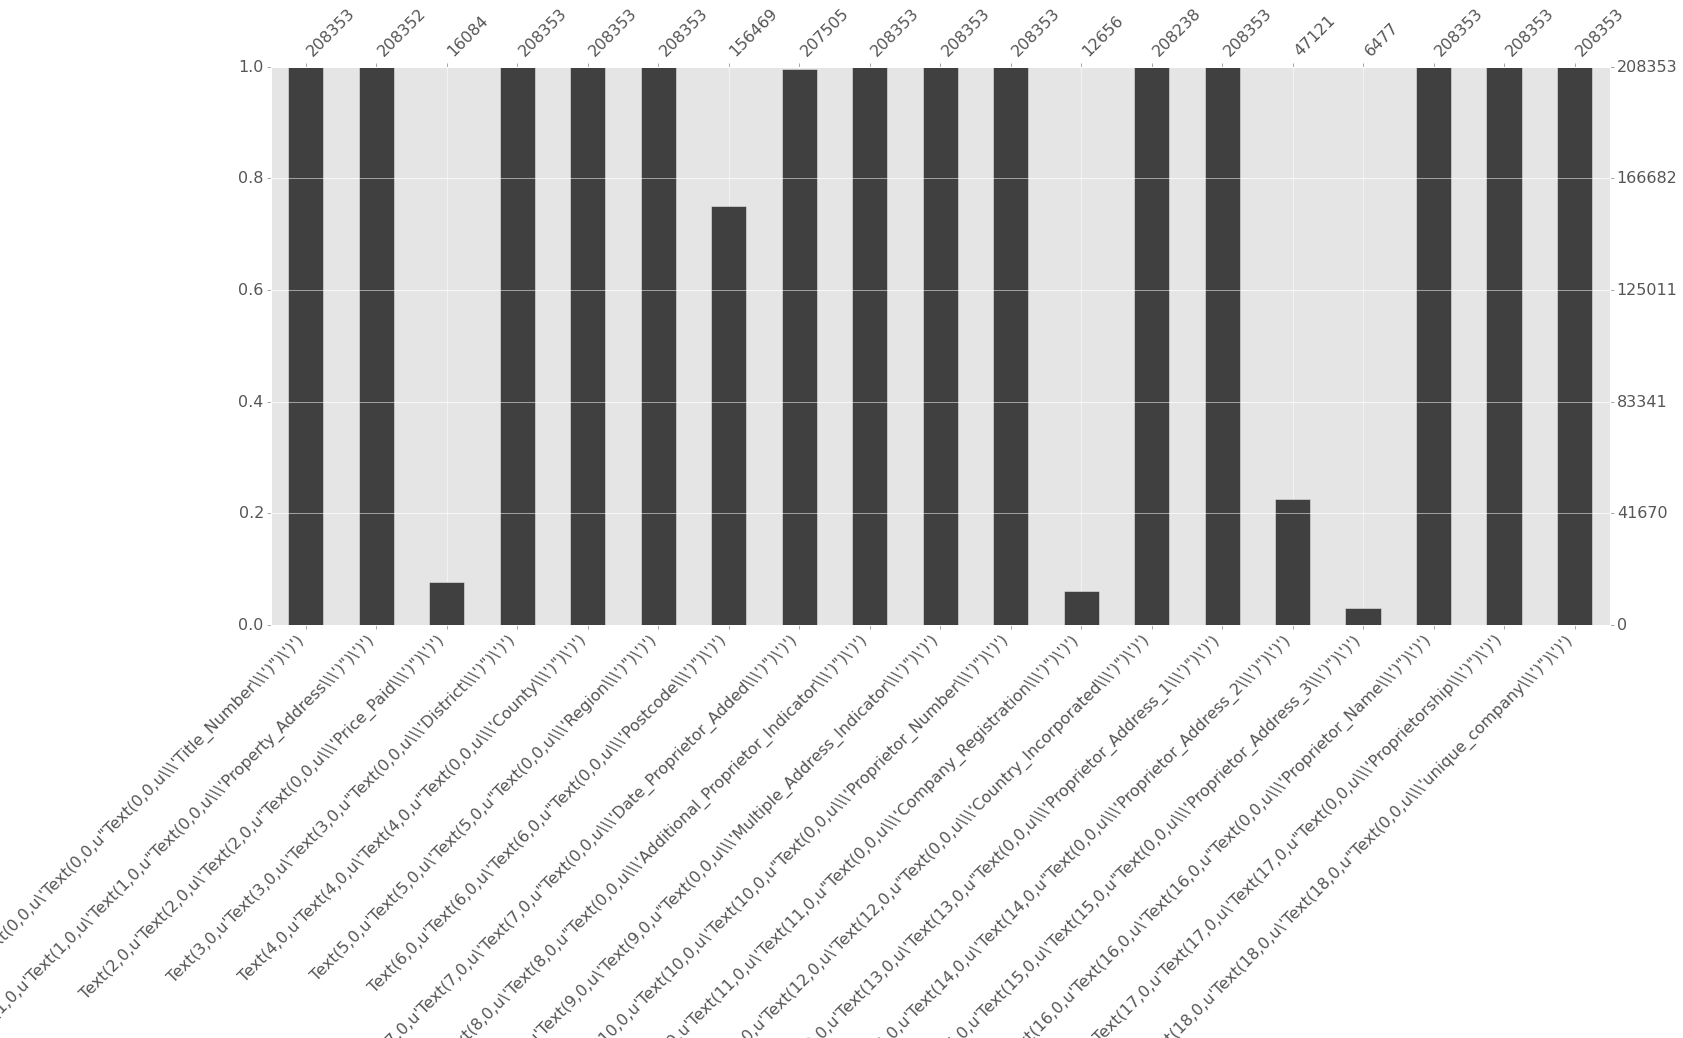

In [8]:
mgno.bar(data)

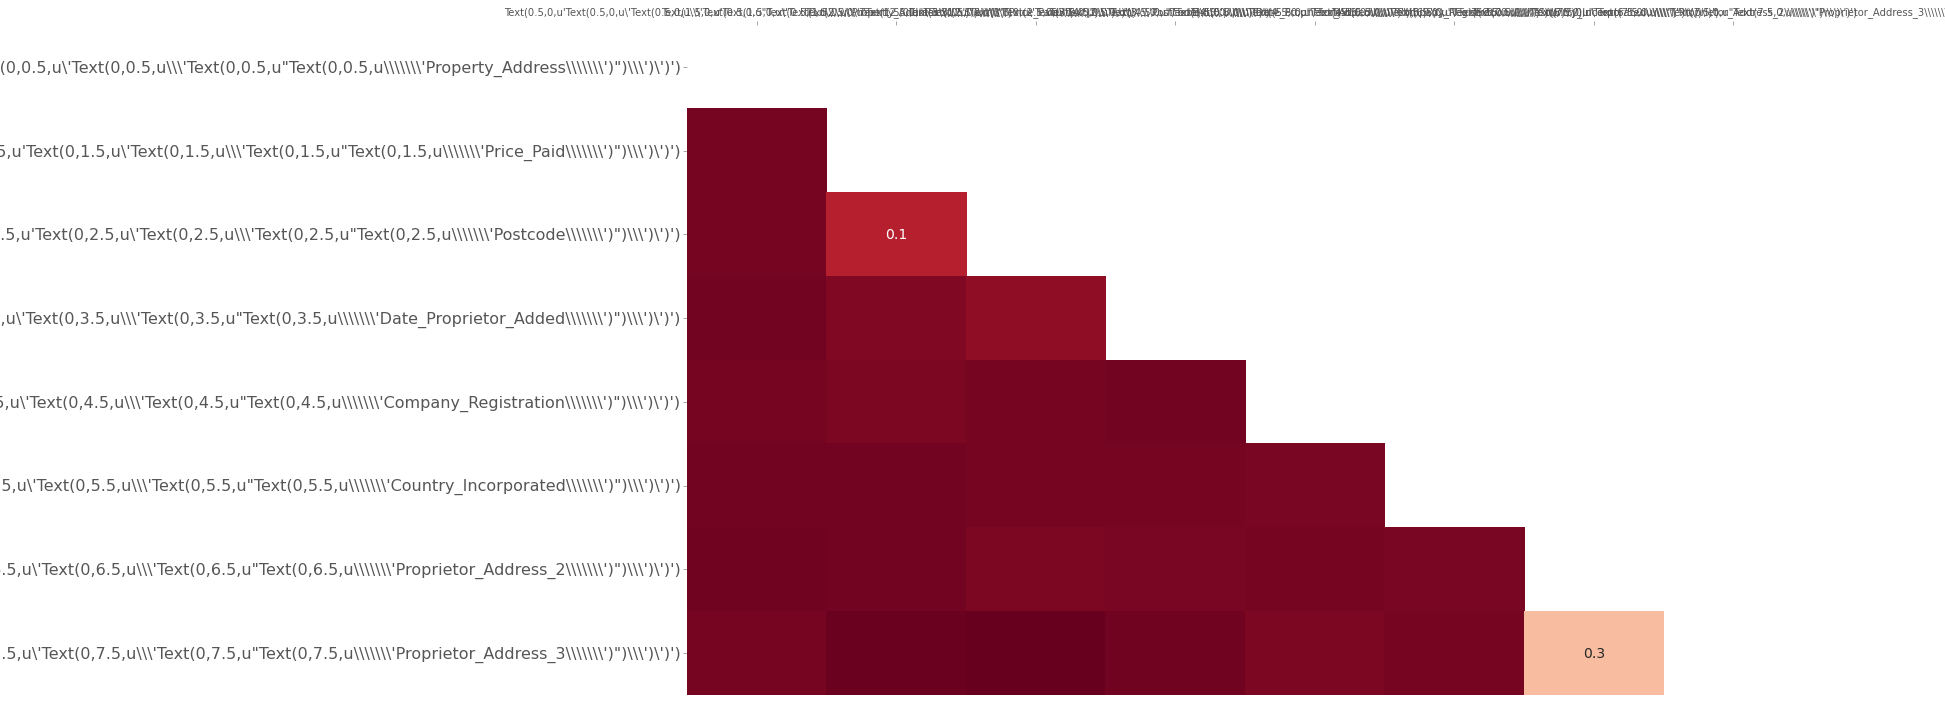

In [9]:
##Correlation matrix for filled values
mgno.heatmap(data)

In [10]:
##Format dates that proprietor was added
data['Date_Proprietor_Added'] = pd.to_datetime(data['Date_Proprietor_Added'])

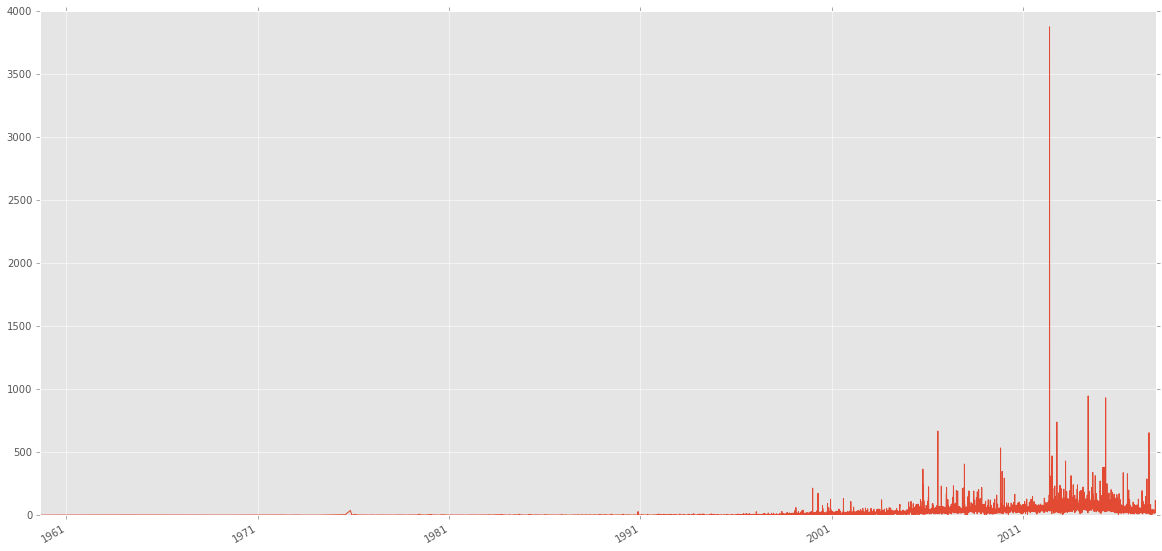

In [11]:
data['Date_Proprietor_Added'].value_counts().plot(figsize=(20,10))

## Geocode properties

# Data dictionary

Write a data dictionary for each field [TO DO]

# Analysis

*Using the original questions from email chain, will need to revise most of them in terms of wha'ts possible with the data.*

How many UK properties are owned by offshore companies compared to 2015?
Offshore here is defined as...

In [12]:
##How many titles are held by overseas companies in 2015 and 2017?
data.groupby('date_snapshot').agg(lambda x: len(x.unique()))['Title_Number']

date_snapshot
2015-10-31    99344
2017-10-01    99219
Name: Title_Number, dtype: int64

How many are valued at >£1m? What’s the total amount? What’s the sq footage? Have these figures increased since July 2015?

In [13]:
##PRICE PAID DATA IS VERY PATCHY SO TREAT WITH EXTREME CAUTION MISSING VALUES OVER 90%
data.groupby('date_snapshot').describe()['Price_Paid']

,count,mean,std,min,25%,50%,75%,max
date_snapshot,,,,,,,,
2015-10-31,6874.0,1.629874e+06,4.821904e+06,1.0,190000.0,438500.0,1171875.0,86031326.0
2017-10-01,9210.0,2.297427e+06,8.176872e+06,1.0,200000.0,490000.0,1389136.0,215399999.0


In [14]:
data.groupby('date_snapshot').median()['Price_Paid']

date_snapshot
2015-10-31    438500.0
2017-10-01    490000.0
Name: Price_Paid, dtype: float64

In [15]:
##What is that crazy expensive property in the 2017 snapshot? Appears to be deadl offices rented to Google...
## http://www.costar.co.uk/en/assets/news/2015/October/GAW-drops-500m-in-West-End-mega-deal/
data[data['Price_Paid'] == 215399999.0]

,Title_Number,Property_Address,Price_Paid,District,County,Region,Postcode,Date_Proprietor_Added,Additional_Proprietor_Indicator,Multiple_Address_Indicator,Proprietor_Number,Company_Registration,Country_Incorporated,Proprietor_Address_1,Proprietor_Address_2,Proprietor_Address_3,Proprietor_Name,Proprietorship,unique_company
date_snapshot,,,,,,,,,,,,,,,,,,,
2017-10-01,NGL690048,"123 Buckingham Palace Road, London (SW1W 9SR)",215399999.0,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,SW1W 9SR,2017-07-07,N,N,1,None,BRITISH VIRGIN ISLANDS,"Nemours Chambers, Road Town, Tortola, British ...",None,None,GC 123 BPR LTD,Limited Company or Public Limited Company,"GC 123 BPR LTDNemours Chambers, Road Town, Tor..."


In [185]:
##Looks like other properties were brought at same time
data['Price_Paid'].sort_values(ascending=False).head(10)

date_snapshot
2017-10-01    215399999.0
2017-10-01    197999000.0
2017-10-01    197999000.0
2017-10-01    180364651.0
2017-10-01    180364651.0
2017-10-01    180364651.0
2017-10-01    179000000.0
2017-10-01    161523809.0
2017-10-01     99000000.0
2017-10-01     93597046.0
Name: Price_Paid, dtype: float64

In [186]:
data[data.Price_Paid >= 93597046.0].sort_values(by='Price_Paid',ascending=False)

,Title_Number,Property_Address,Price_Paid,District,County,Region,Postcode,Date_Proprietor_Added,Additional_Proprietor_Indicator,Multiple_Address_Indicator,Proprietor_Number,Company_Registration,Country_Incorporated,Proprietor_Address_1,Proprietor_Address_2,Proprietor_Address_3,Proprietor_Name,Proprietorship,unique_companny,unique_company
date_snapshot,,,,,,,,,,,,,,,,,,,,
2017-10-01,NGL690048,"123 Buckingham Palace Road, London (SW1W 9SR)",215399999.0,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,SW1W 9SR,2017-07-07,N,N,1,None,BRITISH VIRGIN ISLANDS,"Nemours Chambers, Road Town, Tortola, British ...",None,None,GC 123 BPR LTD,Limited Company or Public Limited Company,"GC 123 BPR LTDNemours Chambers, Road Town, Tor...","GC 123 BPR LTDNemours Chambers, Road Town, Tor..."
2017-10-01,NGL953168,"48-50 New Bond Street, London (W1S 1BJ)",197999000.0,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,W1S 1BJ,2016-07-12,N,N,1,None,JERSEY,"47 Esplanade, St Helier, Jersey, JE1 0BD",None,None,NBS TRUSTEE ONE LIMITED,Limited Company or Public Limited Company,"NBS TRUSTEE ONE LIMITED47 Esplanade, St Helier...","NBS TRUSTEE ONE LIMITED47 Esplanade, St Helier..."
2017-10-01,NGL953168,"48-50 New Bond Street, London (W1S 1BJ)",197999000.0,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,W1S 1BJ,2016-07-12,N,N,2,None,JERSEY,"47 Esplanade, St Helier, Jersey, JE1 0BD",None,None,NBS TRUSTEE TWO LIMITED,Limited Company or Public Limited Company,"NBS TRUSTEE TWO LIMITED47 Esplanade, St Helier...","NBS TRUSTEE TWO LIMITED47 Esplanade, St Helier..."
2017-10-01,TGL326111,"Ground Floor Premises, Bankside 3, 90 Southwar...",180364651.0,SOUTHWARK,GREATER LONDON,GREATER LONDON,SE1 0TF,2017-07-13,N,N,1,None,JERSEY,"St. Paul's Gate, New Street, St Helier, Jersey...",None,None,RREEF BANKSIDE III LIMITED,Limited Company or Public Limited Company,"RREEF BANKSIDE III LIMITEDSt. Paul's Gate, New...","RREEF BANKSIDE III LIMITEDSt. Paul's Gate, New..."
2017-10-01,TGL298368,"Ground Floor and Basement, 90 Southwark Street...",180364651.0,SOUTHWARK,GREATER LONDON,GREATER LONDON,SE1 0TF,2017-07-13,N,N,1,None,JERSEY,"St. Paul's Gate, New Street, St Helier, Jersey...",None,None,RREEF BANKSIDE III LIMITED,Limited Company or Public Limited Company,"RREEF BANKSIDE III LIMITEDSt. Paul's Gate, New...","RREEF BANKSIDE III LIMITEDSt. Paul's Gate, New..."
2017-10-01,TGL270288,"90 Southwark Street, London (SE1 0TF)",180364651.0,SOUTHWARK,GREATER LONDON,GREATER LONDON,SE1 0TF,2017-07-13,N,N,1,None,JERSEY,"St. Paul's Gate, New Street, St Helier, Jersey...",None,None,RREEF BANKSIDE III LIMITED,Limited Company or Public Limited Company,"RREEF BANKSIDE III LIMITEDSt. Paul's Gate, New...","RREEF BANKSIDE III LIMITEDSt. Paul's Gate, New..."
2017-10-01,NGL682568,"Mitre House, 120 Cheapside and Compter House 4...",179000000.0,CITY OF LONDON,GREATER LONDON,GREATER LONDON,NaN,2017-09-13,N,N,1,None,LUXEMBOURG,"45 Rue Des Scillas, L-2529 Howald, Luxembourg",None,None,ONE WOOD STREET ACQUICO 1 S.A.R.L,Corporate Body,ONE WOOD STREET ACQUICO 1 S.A.R.L45 Rue Des Sc...,ONE WOOD STREET ACQUICO 1 S.A.R.L45 Rue Des Sc...
2017-10-01,LN125280,land and buildings on the west side of Hercule...,161523809.0,LAMBETH,GREATER LONDON,GREATER LONDON,NaN,2017-07-24,N,N,1,None,GUERNSEY,"Third floor, 1 New Change, London EC4M 9AF","First Floor, Albert House, South Esplanade, St...",None,ALTER DOMUS (GUERNSEY) LIMITED,Limited Company or Public Limited Company,"ALTER DOMUS (GUERNSEY) LIMITEDThird floor, 1 N...","ALTER DOMUS (GUERNSEY) LIMITEDThird floor, 1 N..."
2017-10-01,NGL676332,"Pinners Hall, 105-108 Old Broad Street, London...",99000000.0,CITY OF LONDON,GREATER LONDON,GREATER LONDON,EC2N 1JB,2017-07-21,N,N,1,None,SINGAPORE,"14 Scotts Road, 06-00, Singapore, 228213",None,None,FAR EAST BROAD STREET (UK) PTE LTD,Limited Company or Public Limited Company,FAR EAST BROAD STREET (UK) PTE LTD14 Scotts Ro...,FAR EAST BROAD STREET (UK) PTE LTD14 Scotts Ro...


How many properties owned by offshore companies are in London? Has this increased since 2015?

In [101]:
df = data.pivot_table(index='County',columns='date_snapshot',values='Title_Number',aggfunc=lambda x: len(x.unique()))\
.sort_values(by='2017-10-01 00:00:00',ascending=False)
df['pct_change'] = df.pct_change(axis=1)['2017-10-01']
df.head(10)

date_snapshot,2015-10-31 00:00:00,2017-10-01 00:00:00,pct_change
County,,,
GREATER LONDON,44022,43311,-0.016151
GREATER MANCHESTER,4988,4916,-0.014435
MERSEYSIDE,2675,2857,0.068037
WEST YORKSHIRE,2714,2568,-0.053795
WEST MIDLANDS,2293,2315,0.009594
SURREY,2195,2121,-0.033713
KENT,1785,1905,0.067227
ESSEX,1801,1822,0.011660
LANCASHIRE,1601,1574,-0.016864


Which areas of UK are most densely populated by buildings owned by anonymous companies? Has this changed since 2015?

In [102]:
df = data.pivot_table(index='Region',columns='date_snapshot',values='Title_Number',aggfunc=lambda x: len(x.unique()))\
.sort_values(by='2017-10-01 00:00:00',ascending=False)
df['pct_change'] = df.pct_change(axis=1)['2017-10-01']
df.head(10)

date_snapshot,2015-10-31 00:00:00,2017-10-01 00:00:00,pct_change
Region,,,
GREATER LONDON,44022,43311,-0.016151
SOUTH EAST,15701,15967,0.016942
NORTH WEST,10885,10977,0.008452
YORKS AND HUMBER,5589,5693,0.018608
SOUTH WEST,5508,5450,-0.010530
WEST MIDLANDS,5117,5168,0.009967
EAST MIDLANDS,4223,4381,0.037414
NORTH,3232,3170,-0.019183
WALES,2697,2672,-0.009270


Which political constituencies have the highest density of buildings owned by anonymous companies? Has this changed since 2015?

How many properties owned by offshore companies are in Kensington & Chelsea / City of Westminster / City of London? Has this increased since 2015?

In [103]:
df = data.pivot_table(index='District',columns='date_snapshot',values='Title_Number',aggfunc=lambda x: len(x.unique()))\
.sort_values(by='2017-10-01 00:00:00',ascending=False)
df['pct_change'] = df.pct_change(axis=1)['2017-10-01']
df.head(10)

date_snapshot,2015-10-31 00:00:00,2017-10-01 00:00:00,pct_change
District,,,
CITY OF WESTMINSTER,13139,11621,-0.115534
KENSINGTON AND CHELSEA,6741,6341,-0.059338
CAMDEN,2380,2490,0.046218
TOWER HAMLETS,1893,2086,0.101955
WANDSWORTH,1893,2020,0.067089
LAMBETH,1639,1768,0.078707
MANCHESTER,1510,1613,0.068212
HAMMERSMITH AND FULHAM,1540,1592,0.033766
LIVERPOOL,1249,1399,0.120096


What is the breakdown of company registration by jurisdiction? How does this compare to 2015?

In [144]:
df = data.pivot_table(index='Country_Incorporated',columns='date_snapshot',values='unique_company',aggfunc=lambda x: len(x.unique()))\
.sort_values(by='2017-10-01 00:00:00',ascending=False)
df['pct_change'] = df.pct_change(axis=1)['2017-10-01']
df.head(20)

date_snapshot,2015-10-31 00:00:00,2017-10-01 00:00:00,pct_change
Country_Incorporated,,,
BRITISH VIRGIN ISLANDS,16930.0,16507.0,-0.024985
JERSEY,9139.0,8676.0,-0.050662
ISLE OF MAN,6593.0,6281.0,-0.047323
GUERNSEY,5019.0,4982.0,-0.007372
PANAMA,1676.0,1477.0,-0.118735
GIBRALTAR,1379.0,1315.0,-0.046410
LUXEMBOURG,1058.0,1202.0,0.136106
SEYCHELLES,1031.0,1099.0,0.065955
HONG KONG,772.0,926.0,0.199482


How many are owned by companies registered in the British Crown Dependencies and Overseas Territories? Has this changed since 2015?

# Additional analysis

Which companies currently own most overseas titles? How has that changed since 2015? Which compaies have acquired or sold lots of properties?

In [40]:
df = data.pivot_table(
        index='Proprietor_Name',
        columns='date_snapshot',
        values='Title_Number',
        aggfunc=lambda x: len(x.unique()))\
    .sort_values(by='2017-10-01 00:00:00', ascending=False)
df['additional_properties'] = df['2017-10-01'] - df['2015-10-31']
df.head(50)

date_snapshot,2015-10-31 00:00:00,2017-10-01 00:00:00,additional_properties
Proprietor_Name,,,
WALLACE PROPERTIES LIMITED,2071.0,1873.0,-198.0
SALCON POWER (HK) LIMITED,763.0,1319.0,556.0
PROFITABLE PLOTS PTE LTD,1205.0,1205.0,0.0
SOLARFAIR INVESTMENTS LIMITED,1181.0,1180.0,-1.0
ABACUS LAND 4 LIMITED,90.0,983.0,893.0
BNP PARIBAS SECURITIES SERVICES TRUST COMPANY (JERSEY) LIMITED,792.0,886.0,94.0
BNP PARIBAS SECURITIES SERVICES TRUST COMPANY LIMITED,752.0,850.0,98.0
LIDL UK GMBH,363.0,562.0,199.0
WESTMINSTER BRIDGE LONDON (REAL ESTATE) B.V.,NaN,504.0,NaN


How many titles have changed hands since 2015 - either by being sold, being 

What are the characteristics of the titles acquired since 2015?

What are the characteristics of the titles sold off since 2015?